In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [5]:
# Path ke folder data
DATA_DIR = "../data/raw/TB_Chest_Radiography_Database"

# Load metadata file
normal_df = pd.read_excel(os.path.join(DATA_DIR, "Normal.metadata.xlsx"))
tb_df = pd.read_excel(os.path.join(DATA_DIR, "Tuberculosis.metadata.xlsx"))

# Rapikan nama kolom
normal_df.columns = normal_df.columns.str.strip().str.lower().str.replace(" ", "_")
tb_df.columns = tb_df.columns.str.strip().str.lower().str.replace(" ", "_")

# Tambahkan label manual
normal_df["label"] = "Normal"
tb_df["label"] = "Tuberculosis"

# Tambahkan kolom path gambar
normal_df["path"] = normal_df["file_name"].apply(lambda x: os.path.join(DATA_DIR, "Normal", f"{x}.png"))
tb_df["path"] = tb_df["file_name"].apply(lambda x: os.path.join(DATA_DIR, "Tuberculosis", f"{x}.png"))

# Gabungkan jadi satu DataFrame
df = pd.concat([normal_df, tb_df], ignore_index=True)
df = df[["path", "label"]]  # keep only relevant columns
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# Lihat hasil
df.head()

,path,label
0,../data/raw/TB_Chest_Radiography_Database\Norm...,Normal
1,../data/raw/TB_Chest_Radiography_Database\Norm...,Normal
2,../data/raw/TB_Chest_Radiography_Database\Norm...,Normal
3,../data/raw/TB_Chest_Radiography_Database\Norm...,Normal
4,../data/raw/TB_Chest_Radiography_Database\Norm...,Normal


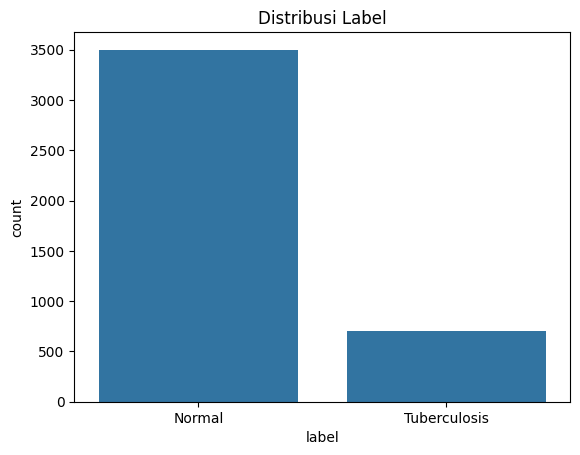

In [6]:
# 📸 3. Visualisasi Jumlah Gambar per Label
sns.countplot(x='label', data=df)
plt.title("Distribusi Label")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Split 80% train_val, 20% test
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Split 80% train, 20% val dari train_val
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 2688
Val size: 672
Test size: 840


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)

# Augmentasi untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Untuk validation & test (tanpa augmentasi)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False  # penting untuk evaluasi/ROC, dsb
)


Found 2688 validated image filenames belonging to 2 classes.
Found 672 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

IMG_SIZE = (224, 224)

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


c:\Users\abbyr\.conda\envs\tbc-detection\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("cnn_model.h5", save_best_only=True)
]

history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)


c:\Users\abbyr\.conda\envs\tbc-detection\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.8406 - loss: 0.5427

84/84 ━━━━━━━━━━━━━━━━━━━━ 75s 880ms/step - accuracy: 0.8409 - loss: 0.5408 - val_accuracy: 0.8661 - val_loss: 0.3417
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.9058 - loss: 0.2336

84/84 ━━━━━━━━━━━━━━━━━━━━ 67s 799ms/step - accuracy: 0.9060 - loss: 0.2333 - val_accuracy: 0.9301 - val_loss: 0.1905
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 71s 845ms/step - accuracy: 0.9191 - loss: 0.2103 - val_accuracy: 0.8408 - val_loss: 0.2760
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.8772 - loss: 0.2913

84/84 ━━━━━━━━━━━━━━━━━━━━ 68s 805ms/step - accuracy: 0.8774 - loss: 0.2908 - val_accuracy: 0.9167 - val_loss: 0.1689
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.9312 - loss: 0.1775

84/84 ━━━━━━━━━━━━━━━━━━━━ 69s 815ms/step - accuracy: 0.9311 - loss: 0.1777 - val_accuracy: 0.9196 - val_loss: 0.1654
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.9341 - loss: 0.1594

84/84 ━━━━━━━━━━━━━━━━━━━━ 67s 793ms/step - accuracy: 0.9341 - loss: 0.1594 - val_accuracy: 0.9390 - val_loss: 0.1367
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 66s 787ms/step - accuracy: 0.9352 - loss: 0.1486 - val_accuracy: 0.9137 - val_loss: 0.2099
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 67s 792ms/step - accuracy: 0.9028 - loss: 0.2598 - val_accuracy: 0.9062 - val_loss: 0.2396
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 67s 791ms/step - accuracy: 0.9253 - loss: 0.1782 - val_accuracy: 0.9301 - val_loss: 0.1454


In [11]:
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"✅ CNN Model Test Accuracy: {test_acc*100:.2f}%")


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - accuracy: 0.9573 - loss: 0.1058
✅ CNN Model Test Accuracy: 95.12%


In [ ]:
prediction = cnn_model.predict(img_array)[0][0]

label = "Tuberculosis" if prediction > 0.5 else "Normal"
confidence = prediction if prediction > 0.5 else 1 - prediction

print(f"Predicted Label: {label} ({confidence*100:.2f}% confidence)")


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # frozen dulu

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)


In [13]:
# Akurasi dan loss di test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")


27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 542ms/step - accuracy: 0.8464 - loss: 0.4297
✅ Test Accuracy: 83.33%


In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load gambar
img_path = "../data/dummy.jpg"  # ganti ini ke path gambar kamu
img = image.load_img(img_path, target_size=(224, 224))

# Ubah ke array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # biar jadi (1, 224, 224, 3)
img_array = img_array / 255.0  # normalisasi

In [15]:
# Pastikan model sudah di-load
# Jika kamu baru restart runtime, load dulu:
# from tensorflow.keras.models import load_model
# model = load_model("best_model.h5")

# Prediksi
prediction = model.predict(img_array)[0][0]

# Threshold bisa 0.5
label = "Tuberculosis" if prediction > 0.5 else "Normal"
confidence = prediction if prediction > 0.5 else 1 - prediction

print(f"Predicted Label: {label} ({confidence*100:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label: Normal (83.09% confidence)
